In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter


# Application of supervised learning : TMDB Box Office Revenue Prediction

## Dataset Presentation

The dataset originates from a Kaggle competition and is available at the following link:  
🔗 [TMDB Box Office Prediction](https://meenal-narsinghani.github.io/Kaggle-TMDB-BO-Prediction/)

It includes data on approximately **3,000 movies**, with diverse information:

- `budget`: the movie's production budget (in USD)
- `runtime`: the movie duration (in minutes)
- `genres`: list of genres (e.g., Action, Comedy)
- `release_date`: release date
- `original_language`: the original language of the film
- `production_companies`: production studios involved
- `cast`: main actors (stored as JSON/text)
- `crew`: crew members including director
- `overview`: text synopsis

The **target variable** is `revenue`, representing the total box office income (in USD). This makes the task a **regression problem**.

The goal of this project is to predict the box office revenue of a movie — a continuous numerical value expressed in dollars — using features that are available before the movie’s release.

**Target variable to predict**: `revenue` (in dollars)

**Type of problem**: `Supervised regression`

**Input features considered**:

- budget (in millions)

- popularity (a numeric score provided by TMDB)

- runtime (duration in minutes)

- release_date (processed to extract release month/year)

- genres (processed into categorical indicators)

- production_companies, cast, crew (optional: to be encoded)

**Predicting box office revenue is valuable** :

- For producers and investors: It helps estimate financial risk before production or release.

- For marketing teams: It supports decision-making about promotional budgets.

- For streaming platforms: It allows prioritization of acquisition or distribution deals.

This kind of prediction model is useful in the film industry.

---


# Data Loading

In [193]:
train_df = pd.read_csv("tmdb-box-office-prediction/train.csv")
test_df = pd.read_csv("tmdb-box-office-prediction/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (3000, 23)
Test shape: (4398, 22)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [194]:
test_df.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,NaN,88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."
2,3003,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",5/23/97,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de..."
3,3004,NaN,6800000,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",http://www.sonyclassics.com/incendies/,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,...,"[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",9/4/10,130.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de..."
4,3005,NaN,2000000,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",NaN,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",2/11/05,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de..."


# Exploratory Data Analysis & Missing Values treatment

In [195]:
# Process for combining test and train to have a complete data analysis
train_df["dataset"] = "train"
test_df["dataset"] = "test"

test_df["revenue"] = None  # to align columns

full_df = pd.concat([train_df, test_df], ignore_index=True)

In [196]:
# Calculate the median
median_budget = full_df['budget'].median()

# Fill missing values with the median
full_df['budget'] = full_df['budget'].fillna(median_budget)

full_df.isnull().sum().sort_values(ascending=False)

belongs_to_collection    5917
homepage                 5032
revenue                  4398
tagline                  1460
Keywords                  669
production_companies      414
production_countries      157
spoken_languages           62
crew                       38
cast                       26
genres                     23
overview                   22
runtime                     6
title                       3
status                      2
poster_path                 2
release_date                1
original_title              0
imdb_id                     0
budget                      0
id                          0
original_language           0
popularity                  0
dataset                     0
dtype: int64

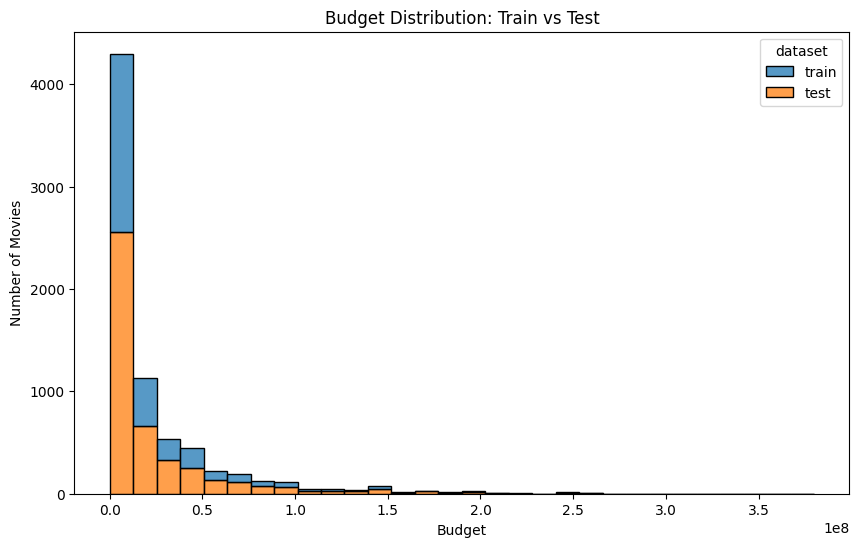

In [197]:
plt.figure(figsize=(10, 6))
sns.histplot(data=full_df, x='budget', bins=30, hue='dataset', multiple='stack')
plt.title("Budget Distribution: Train vs Test")
plt.xlabel("Budget")
plt.ylabel("Number of Movies")
plt.show()


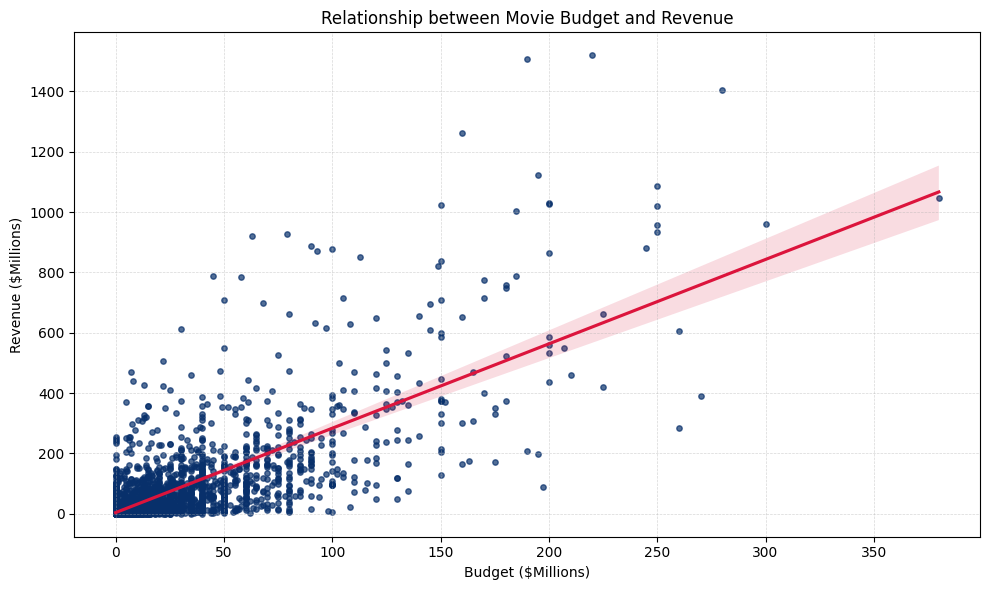

In [198]:

# budget and revenue are in millions
full_df['budget'] = full_df['budget'].astype(float) / 1e6
full_df['revenue'] = full_df['revenue'].astype(float) / 1e6

filtered_df = full_df[(full_df['budget'].notnull()) & 
                      (full_df['revenue'].notnull()) &
                      (full_df['dataset'] == 'train')]  # Only training set has revenue

plt.figure(figsize=(10, 6))
sns.regplot(
    data=filtered_df,
    x='budget',
    y='revenue',
    scatter_kws={'color': '#08306B', 'alpha': 0.7, 's': 15},
    line_kws={'color': 'crimson'},
    ci=95
)

plt.xlabel("Budget ($Millions)")
plt.ylabel("Revenue ($Millions)")
plt.title("Relationship between Movie Budget and Revenue")

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


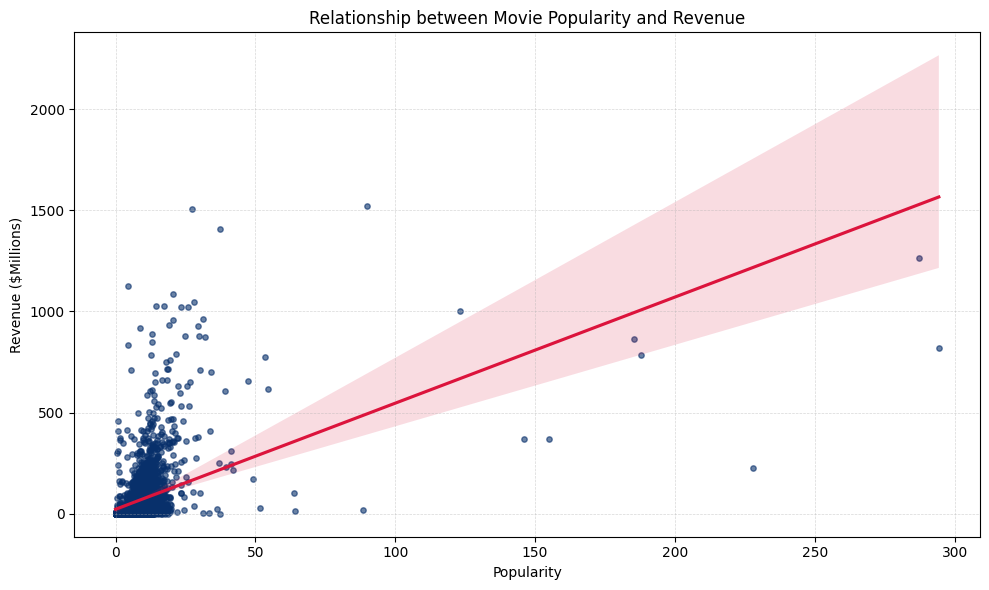

In [199]:
# Filter to use only training data with known revenue and popularity
filtered_df = full_df[
    (full_df['revenue'].notnull()) &
    (full_df['popularity'].notnull()) &
    (full_df['dataset'] == 'train')
]

plt.figure(figsize=(10, 6))
sns.regplot(
    data=filtered_df,
    x='popularity',
    y='revenue',
    scatter_kws={'color': '#08306B', 'alpha': 0.6, 's': 15},
    line_kws={'color': 'crimson'},
    ci=95
)

plt.xlabel("Popularity")
plt.ylabel("Revenue ($Millions)")
plt.title("Relationship between Movie Popularity and Revenue")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()


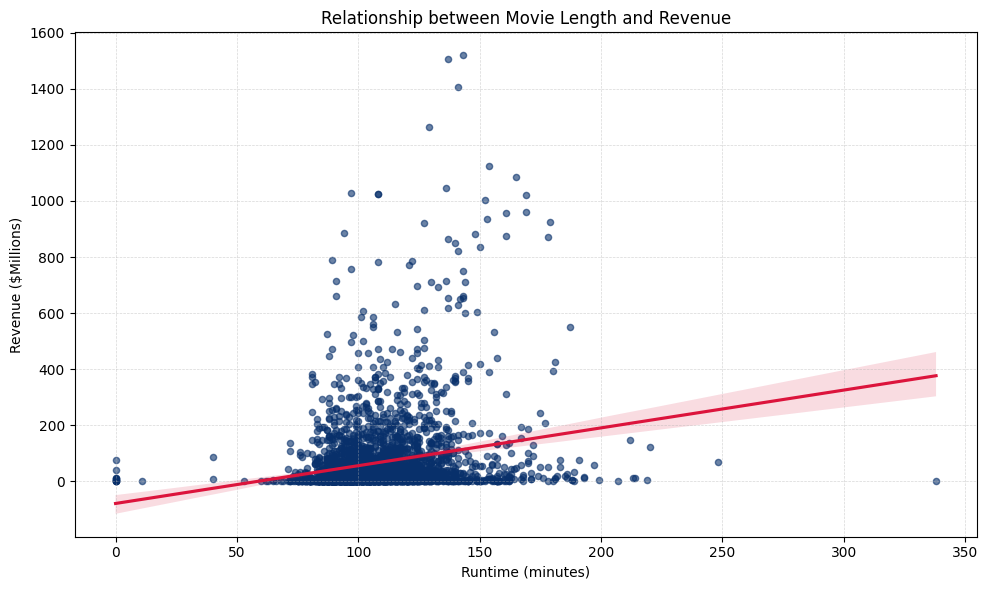

In [200]:
# Filter: only rows with revenue and runtime (and from training set)
filtered_df = full_df[
    (full_df['revenue'].notnull()) &
    (full_df['runtime'].notnull()) &
    (full_df['dataset'] == 'train')
]

plt.figure(figsize=(10, 6))
sns.regplot(
    data=filtered_df,
    x='runtime',
    y='revenue',
    scatter_kws={'color': '#08306B', 'alpha': 0.6, 's': 20},
    line_kws={'color': 'crimson'},
    ci=95
)

plt.xlabel("Runtime (minutes)")
plt.ylabel("Revenue ($Millions)")
plt.title("Relationship between Movie Length and Revenue")
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

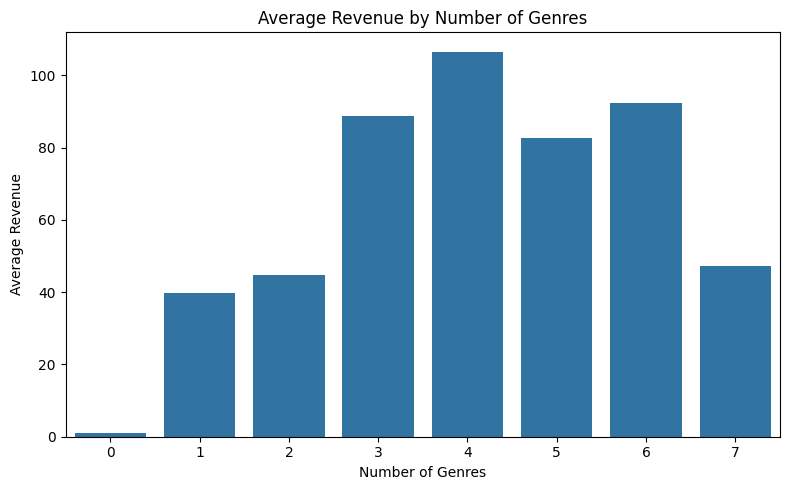

In [201]:
def extract_genre_list(genre_str):
    try:
        genre_data = ast.literal_eval(genre_str)
        return [d['name'] for d in genre_data]
    except:
        return []

full_df['genre_list'] = full_df['genres'].apply(extract_genre_list)
full_df['num_genres'] = full_df['genre_list'].apply(len)

df_plot = full_df[
    (full_df['dataset'] == 'train') &
    (full_df['revenue'].notnull())
].copy()

avg_rev = df_plot.groupby('num_genres')['revenue'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=avg_rev, x='num_genres', y='revenue')
plt.xlabel("Number of Genres")
plt.ylabel("Average Revenue")
plt.title("Average Revenue by Number of Genres")
plt.tight_layout()
plt.show()

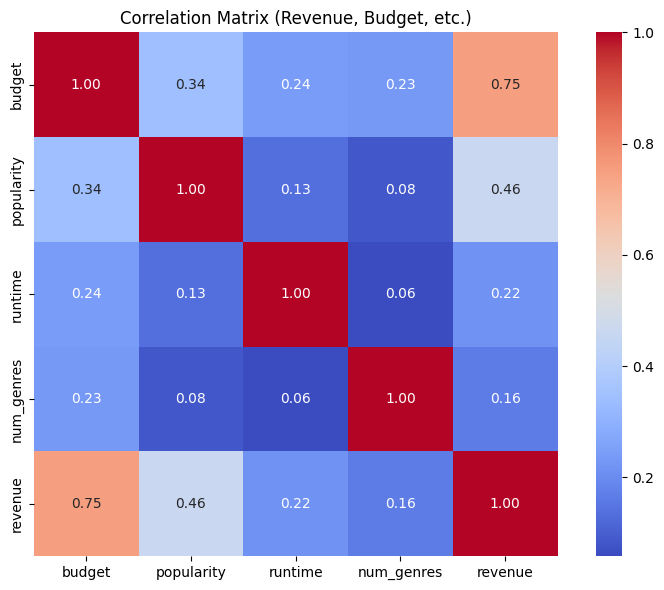

In [202]:
corr_df = full_df[full_df['dataset'] == 'train'].copy()

corr_vars = ['budget', 'popularity', 'runtime', 'num_genres', 'revenue']
corr_df = corr_df[corr_vars].dropna()

plt.figure(figsize=(8, 6))
corr_matrix = corr_df.corr(numeric_only=True)

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix (Revenue, Budget, etc.)")
plt.tight_layout()
plt.show()


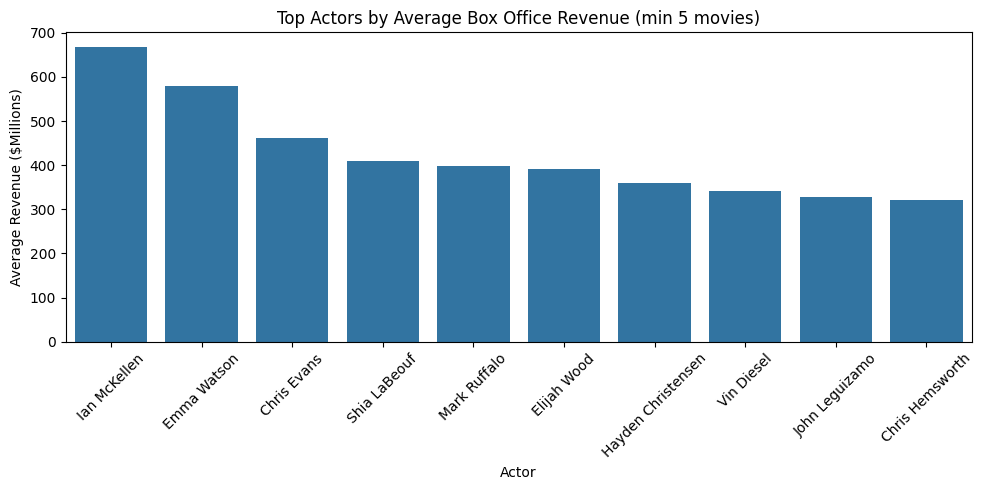

In [203]:
def extract_actor_names(cast_str, max_actors=3):
    try:
        cast_list = ast.literal_eval(cast_str)
        return [actor['name'] for actor in cast_list[:max_actors]]  # top 3 actors
    except:
        return []

train_df = full_df[full_df['dataset'] == 'train'].copy()
train_df['cast_list'] = train_df['cast'].apply(lambda x: extract_actor_names(x, max_actors=3))

cast_revenue_df = train_df[['cast_list', 'revenue']].explode('cast_list')
cast_revenue_df = cast_revenue_df.dropna(subset=['cast_list', 'revenue'])

top_actors = (
    cast_revenue_df
    .groupby('cast_list')['revenue']
    .agg(['count', 'mean'])
    .rename(columns={'count': 'num_movies', 'mean': 'avg_revenue'})
    .sort_values(by='num_movies', ascending=False)
)

# Option : keep only actors played in at least 5 movies
top_actors_filtered = top_actors[top_actors['num_movies'] >= 5].sort_values(by='avg_revenue', ascending=False)
top_actors_filtered.head(10)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=top_actors_filtered.head(10).index,
    y=top_actors_filtered.head(10)['avg_revenue']
)
plt.xticks(rotation=45)
plt.ylabel("Average Revenue ($Millions)")
plt.xlabel("Actor")
plt.title("Top Actors by Average Box Office Revenue (min 5 movies)")
plt.tight_layout()
plt.show()


/tmp/ipykernel_157402/1879700723.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  full_df['release_date'] = pd.to_datetime(full_df['release_date'], errors='coerce')


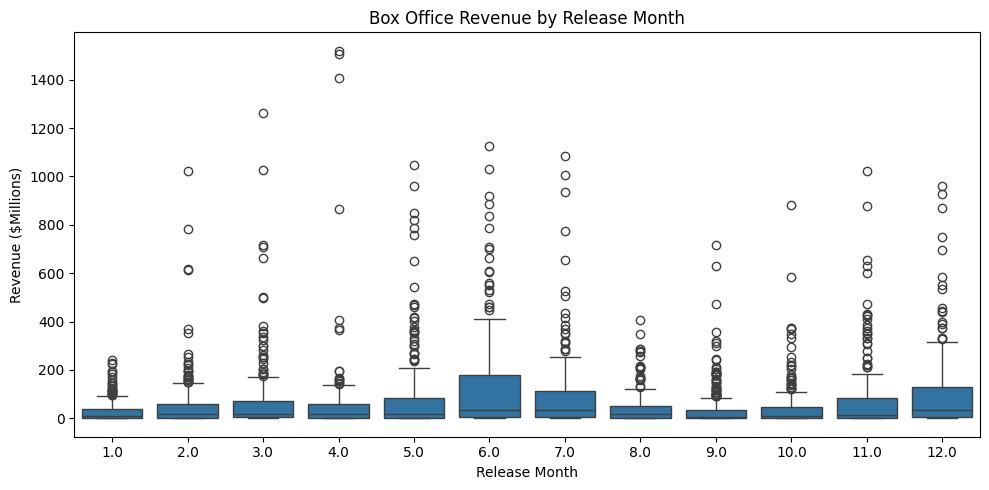

In [204]:
full_df['release_date'] = pd.to_datetime(full_df['release_date'], errors='coerce')

full_df['release_year'] = full_df['release_date'].dt.year
full_df['release_month'] = full_df['release_date'].dt.month
full_df['release_day'] = full_df['release_date'].dt.day
full_df['release_quarter'] = full_df['release_date'].dt.quarter

df_plot = full_df[(full_df['dataset'] == 'train') & (full_df['revenue'].notnull())].copy()
df_plot['revenue'] = df_plot['revenue']

plt.figure(figsize=(10, 5))
sns.boxplot(data=df_plot, x='release_month', y='revenue')
plt.xlabel("Release Month")
plt.ylabel("Revenue ($Millions)")
plt.title("Box Office Revenue by Release Month")
plt.tight_layout()
plt.show()


# Training and Evaluating

In [205]:
features = ['budget', 'popularity', 'runtime', 'num_genres']

train_data = full_df[full_df['dataset'] == 'train'].dropna(subset=features + ['revenue']).copy()
X = train_data[features]
y = np.log1p(train_data['revenue']) # Transformation log cuz revenue is very skewed

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## LinearRegression with 4 features

In [206]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val_actual = np.expm1(y_val)

print("MAE:", mean_absolute_error(y_val_actual, y_pred))
print("RMSE:", root_mean_squared_error(y_val_actual, y_pred))
print("R²:", r2_score(y_val_actual, y_pred))

MAE: 202.69290566013999
RMSE: 2810.795474726209
R²: -568.9991110139887


## Random Forest with 4 features

In [207]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_log = rf.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val_actual = np.expm1(y_val)

print("Random Forest MAE:", mean_absolute_error(y_val_actual, y_pred))
print("Random Forest RMSE:", root_mean_squared_error(y_val_actual, y_pred))
print("Random Forest R²:", r2_score(y_val_actual, y_pred))


Random Forest MAE: 37.20025449391286
Random Forest RMSE: 73.81354159509523
Random Forest R²: 0.6069138213544872


## XGBoost with 4 features

In [ ]:
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

y_pred_log = xgb.predict(X_val)
y_pred = np.expm1(y_pred_log)

print("XGBoost MAE:", mean_absolute_error(y_val_actual, y_pred))
print("XGBoost RMSE:", root_mean_squared_error(y_val_actual, y_pred))
print("XGBoost R²:", r2_score(y_val_actual, y_pred))


XGBoost MAE: 39.456330347742075
XGBoost RMSE: 77.61119818927361
XGBoost R²: 0.5654252754578197


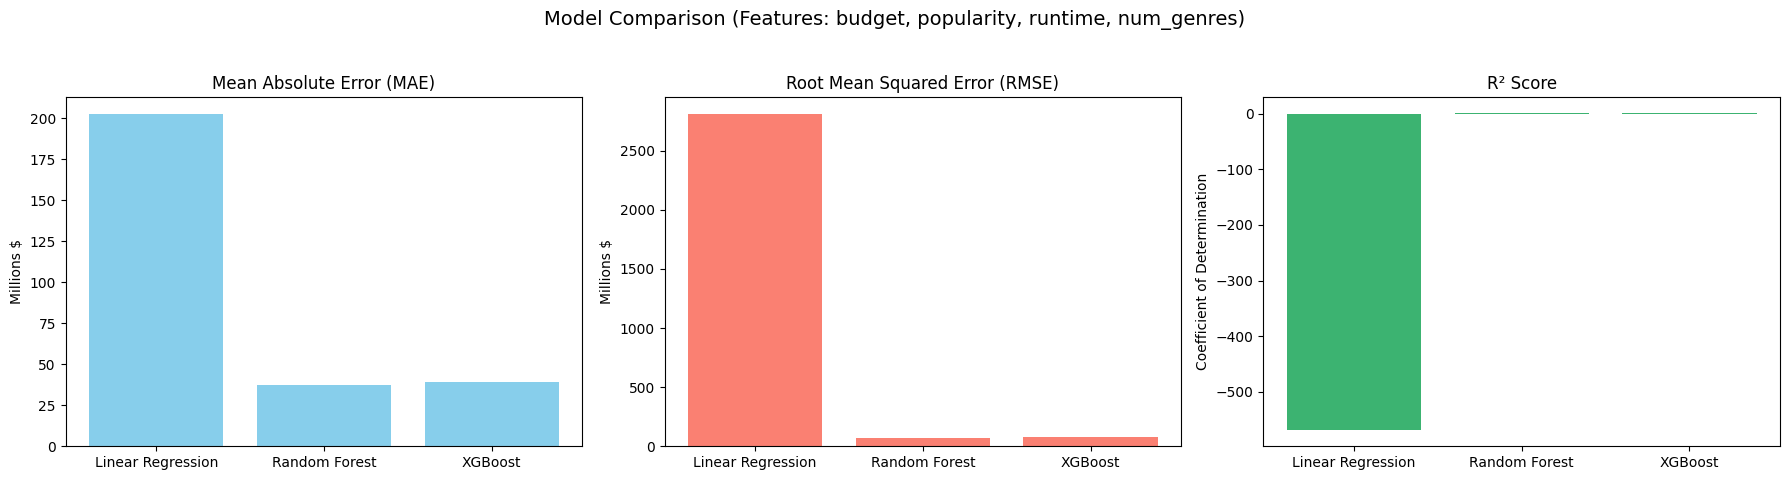

In [209]:
# Results
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
mae = [202.69, 37.20, 39.46]
rmse = [2810.79, 73.81, 77.61]
r2 = [-568.99, 0.607, 0.565]

df_scores = pd.DataFrame({
    'Model': model_names,
    'MAE': mae,
    'RMSE': rmse,
    'R²': r2
})

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Barplot MAE
axes[0].bar(df_scores['Model'], df_scores['MAE'], color='skyblue')
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylabel('Millions $')

# Barplot RMSE
axes[1].bar(df_scores['Model'], df_scores['RMSE'], color='salmon')
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].set_ylabel('Millions $')

# Barplot R²
axes[2].bar(df_scores['Model'], df_scores['R²'], color='mediumseagreen')
axes[2].set_title('R² Score')
axes[2].set_ylabel('Coefficient of Determination')

plt.suptitle("Model Comparison (Features: budget, popularity, runtime, num_genres)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


### Discussing these results

In this experiment, we compared three supervised regression models — **Linear Regression**, **Random Forest**, and **XGBoost** — using four basic input features: `budget`, `popularity`, `runtime`, and `num_genres`.

The results clearly show that:

- **Linear Regression** failed to model the data properly, likely due to the non-linear relationships between the input features and the target variable (`revenue`).
- Both **Random Forest** and **XGBoost** significantly outperformed the linear model, with **Random Forest achieving the best performance overall** (lowest MAE and RMSE, highest R²).
- Despite their simplicity, the selected features already provide meaningful predictive power when used with non-linear models.

This confirms that even basic numerical features can lead to reasonable results, especially when combined with robust machine learning models such as Random Forest. Further performance improvements are expected by incorporating additional processed features such as release date, genres, cast, and crew information. SO, that we will do now.


In [210]:
#------------------------------------- Release_date -------------------------------#

full_df['release_date'] = pd.to_datetime(full_df['release_date'], errors='coerce')

# Month (1 à 12)
full_df['release_month'] = full_df['release_date'].dt.month

# Year (ex: 2012)
full_df['release_year'] = full_df['release_date'].dt.year

# Quarter (1 à 4)
full_df['release_quarter'] = full_df['release_date'].dt.quarter

#------------------------------------- genres -------------------------------#

def extract_genre_list(genre_str):
    try:
        genres = ast.literal_eval(genre_str)
        return [g['name'] for g in genres]
    except:
        return []

full_df['genre_list'] = full_df['genres'].apply(extract_genre_list)

mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(
    mlb.fit_transform(full_df['genre_list']),
    columns=mlb.classes_,
    index=full_df.index
)

#--------------------------------------------- cast ----------------------#

def extract_cast(cast_str, max_actors=3):
    try:
        cast_list = ast.literal_eval(cast_str)
        return [c['name'] for c in cast_list[:max_actors]]
    except:
        return []

full_df['cast_list'] = full_df['cast'].apply(lambda x: extract_cast(x, max_actors=3))

train_cast = full_df[(full_df['dataset'] == 'train') & (full_df['revenue'].notnull())]['cast_list']
actor_counts = Counter(actor for cast in train_cast for actor in cast)

top_actors = [actor for actor, count in actor_counts.items() if count >= 10]

def actor_presence(cast, top_actor_list):
    return {f"has_actor_{actor}": int(actor in cast) for actor in top_actor_list}

actor_features = full_df['cast_list'].apply(lambda cast: actor_presence(cast, top_actors))
actor_encoded = pd.DataFrame(actor_features.tolist(), index=full_df.index)

#----------------------------- director (crew) ---------------------------#
def extract_director(crew_str):
    try:
        crew_list = ast.literal_eval(crew_str)
        for member in crew_list:
            if member.get('job') == 'Director':
                return member['name']
    except:
        return None

full_df['director'] = full_df['crew'].apply(extract_director)

top_directors = (
    full_df[full_df['dataset'] == 'train']['director']
    .value_counts()
    .head(20)
    .index
)

full_df['top_director'] = full_df['director'].apply(lambda x: x if x in top_directors else 'Other')


In [211]:
full_features = features + ['release_month', 'release_year', 'release_quarter']

train_data_full = full_df[full_df['dataset'] == 'train'].dropna(subset=full_features + ['revenue']).copy()


genre_encoded_train = genre_encoded.loc[train_data_full.index]
actor_encoded_train = actor_encoded.loc[train_data_full.index]
director_encoded = pd.get_dummies(full_df['top_director'], prefix='director')
director_encoded_train = director_encoded.loc[train_data_full.index]


X_full = train_data_full[full_features]
X_full = pd.concat([X_full, genre_encoded_train], axis=1)
X_full = pd.concat([X_full, actor_encoded_train], axis=1)
X_full = pd.concat([X_full, director_encoded_train], axis=1)

y_full = np.log1p(train_data_full['revenue']) # Transformation log cuz revenue is very skewed

X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42
)

## LinearRegression with 8 features

In [213]:
model = LinearRegression()
model.fit(X_train_full, y_train_full)

y_pred_log = model.predict(X_val_full)
y_pred = np.expm1(y_pred_log)
y_val_actual = np.expm1(y_val_full)

print("MAE:", mean_absolute_error(y_val_actual, y_pred))
print("RMSE:", root_mean_squared_error(y_val_actual, y_pred))
print("R²:", r2_score(y_val_actual, y_pred))

MAE: 113.62805232364587
RMSE: 1080.8324386037057
R²: -83.28153331721659


## Random Forest with 8 features

In [263]:
rf = RandomForestRegressor(n_estimators=79, random_state=42) # Best n_estimators found.
rf.fit(X_train_full, y_train_full)

y_pred_log = rf.predict(X_val_full)
y_pred = np.expm1(y_pred_log)
y_val_actual = np.expm1(y_val_full)

print("Random Forest MAE:", mean_absolute_error(y_val_actual, y_pred))
print("Random Forest RMSE:", root_mean_squared_error(y_val_actual, y_pred))
print("Random Forest R²:", r2_score(y_val_actual, y_pred))


Random Forest MAE: 35.09077862776076
Random Forest RMSE: 69.15646778406584
Random Forest R²: 0.654950586510172


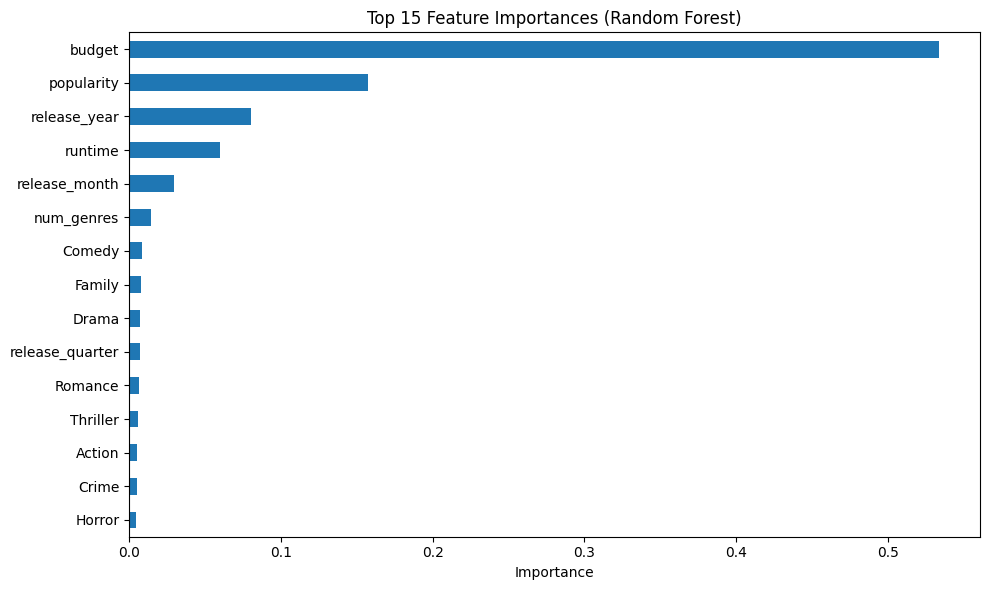

In [266]:
importances = rf.feature_importances_
features = X_train_full.columns

# Top 15
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False).head(15)
feat_importance.plot(kind='barh', figsize=(10, 6))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## XGBoost with 8 features

In [ ]:
xgb = XGBRegressor(n_estimators=30, random_state=42) # best n_estimator found.
xgb.fit(X_train_full, y_train_full)

y_pred_log = xgb.predict(X_val_full)
y_pred = np.expm1(y_pred_log)

print("XGBoost MAE:", mean_absolute_error(y_val_actual, y_pred))
print("XGBoost RMSE:", root_mean_squared_error(y_val_actual, y_pred))
print("XGBoost R²:", r2_score(y_val_actual, y_pred))


XGBoost MAE: 36.1897987499213
XGBoost RMSE: 71.14616076649142
XGBoost R²: 0.6348102110372009


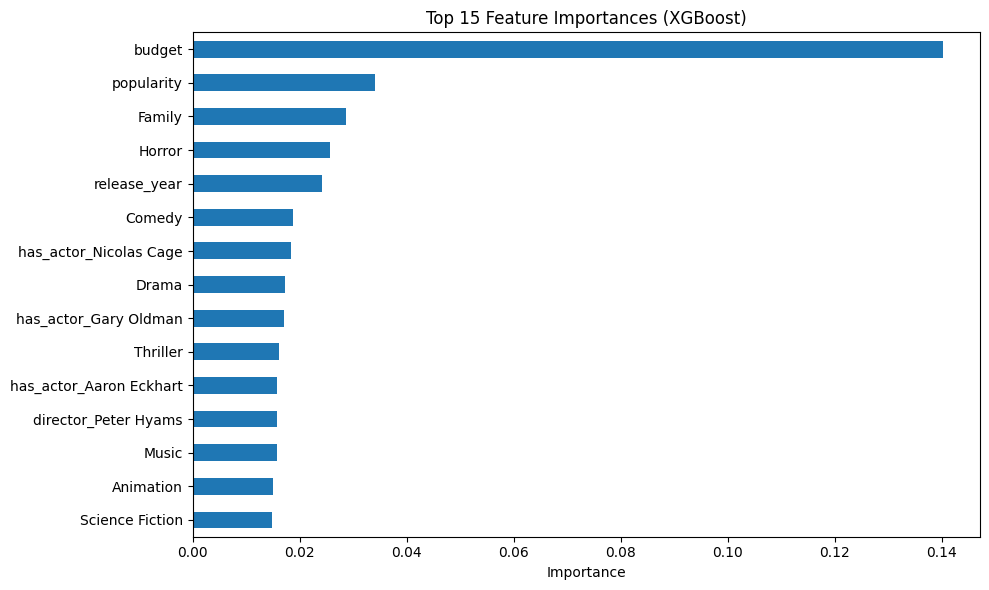

In [267]:
importances = xgb.feature_importances_
features = X_train_full.columns

# Top 15
feat_importance = pd.Series(importances, index=features).sort_values(ascending=False).head(15)
feat_importance.plot(kind='barh', figsize=(10, 6))
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


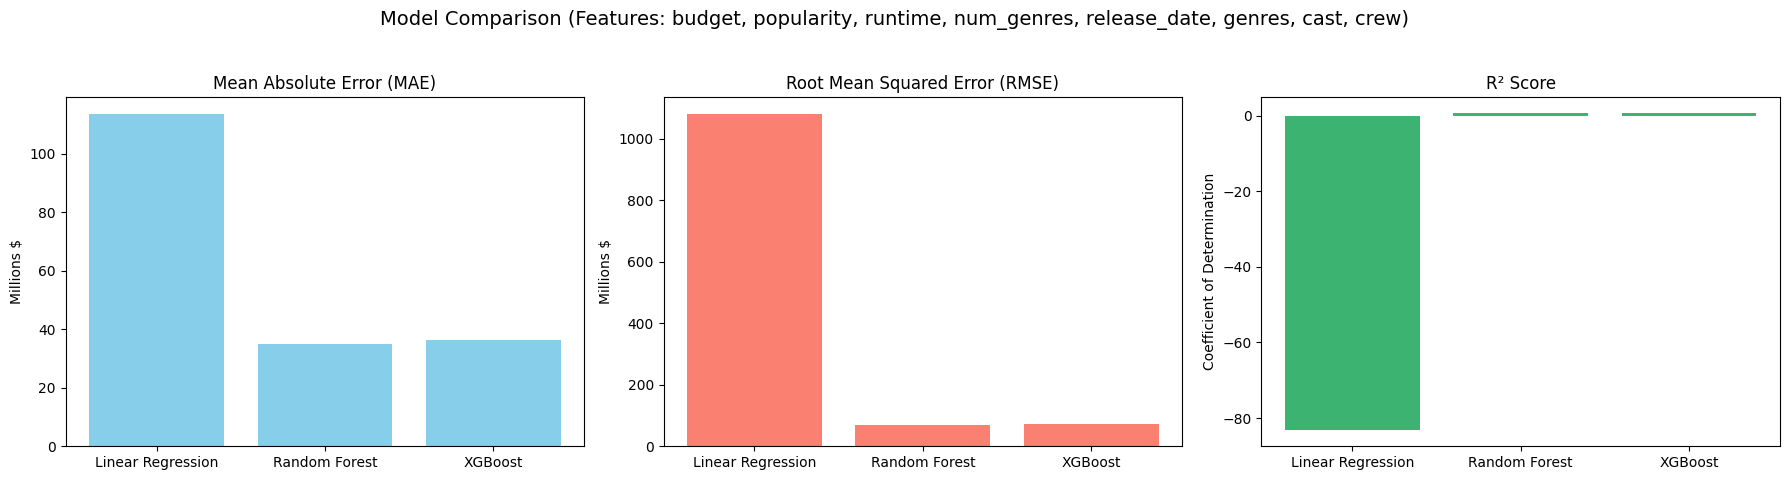

In [264]:
# Results
model_names = ['Linear Regression', 'Random Forest', 'XGBoost']
mae = [113.63, 35.13, 36.18]
rmse = [1080.83, 69.28, 71.14]
r2 = [-83.28, 0.655, 0.634]

df_scores = pd.DataFrame({
    'Model': model_names,
    'MAE': mae,
    'RMSE': rmse,
    'R²': r2
})

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Barplot MAE
axes[0].bar(df_scores['Model'], df_scores['MAE'], color='skyblue')
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylabel('Millions $')

# Barplot RMSE
axes[1].bar(df_scores['Model'], df_scores['RMSE'], color='salmon')
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].set_ylabel('Millions $')

# Barplot R²
axes[2].bar(df_scores['Model'], df_scores['R²'], color='mediumseagreen')
axes[2].set_title('R² Score')
axes[2].set_ylabel('Coefficient of Determination')

plt.suptitle("Model Comparison (Features: budget, popularity, runtime, num_genres, release_date, genres, cast, crew)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()


### Interpretation of Results

The chart compares the performance of three regression models — **Linear Regression**, **Random Forest**, and **XGBoost** — in predicting movie revenue, using a comprehensive set of features including `budget`, `popularity`, `runtime`, `num_genres`, `release_date`, `genres`, `cast`, and `crew`.

#### Key observations:

- **Linear Regression** performed very poorly across all metrics:
  - MAE and RMSE are extremely high, suggesting that it is unable to capture the underlying non-linear relationships in the data.
  - The R² score is negative, indicating that the model performs worse than simply predicting the mean revenue.

- **Random Forest** and **XGBoost** both significantly outperform Linear Regression:
  - Much lower MAE and RMSE values, indicating better prediction accuracy.
  - R² scores close to 0 suggest modest explanatory power — the models are starting to capture patterns, but there’s still room for improvement.

- **Random Forest** slightly outperforms XGBoost in this setting, although the difference is small.

# Conclusion:
Tree-based models like Random Forest and XGBoost are far more suitable than linear models for this kind of problem. The improved performance demonstrates the value of enriched features (especially from `genres`, `cast`, and `crew`). Further improvements could be achieved through hyperparameter tuning or adding more structured external data.

## Discussion: Have We Solved a Problem With This Processing?

The objective of this project was to predict the box office revenue of movies using structured data from the TMDB dataset. Through extensive feature engineering (including budget, popularity, runtime, genres, cast, director, and release date) and the use of advanced non-linear models like Random Forest and XGBoost, we have built a predictive system that achieves promising results.

While linear models failed to capture the complexity of the task (negative R²), both Random Forest and XGBoost achieved reasonable performance with R² scores around 0.64. This means that a substantial portion of the revenue variance can be explained by the available features.

We therefore conclude that this processing pipeline does **effectively address the problem** of revenue prediction, even if the solution is not perfect. The models could be further improved with additional external data (e.g. marketing spend, release competition, actor popularity metrics), but within the scope of the provided dataset, the solution is relevant and informative.

Overall, this pipeline could serve as a valuable tool for the film industry to estimate potential revenue based on early production data.

